In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

from PIL import Image

import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2


import seaborn as sns


from mirror_extractor import MirrorExtractor


In [12]:
def extract_one_mirror_from_images(img_path_list, mirror_id, extractor):
    mirror_list = []
    for path in img_path_list:
        print(path)
        img = np.array(Image.open(path).convert('RGB'))
        x_coords, y_coords = extractor.get_coords(mirror_id)
        cropped = extractor.extract_polygon_region_cv2(img, x_coords, y_coords)
        mirror_list.append(cropped)
    return mirror_list

def compute_mirror_features(mirror_list):
    """
    Oblicza cechy dla każdego lustra
    """
    features = []
    
    for mirror in mirror_list:
        feature_dict = {}
        
        # 1. Statystyki podstawowe dla każdego kanału RGB
        for i, color in enumerate(['R', 'G', 'B']):
            feature_dict[f'{color}_mean'] = np.mean(mirror[:, :, i])
            feature_dict[f'{color}_std'] = np.std(mirror[:, :, i])
            feature_dict[f'{color}_median'] = np.median(mirror[:, :, i])
            feature_dict[f'{color}_min'] = np.min(mirror[:, :, i])
            feature_dict[f'{color}_max'] = np.max(mirror[:, :, i])
        
        # 2. Jasność ogólna
        feature_dict['brightness'] = np.mean(mirror)
        feature_dict['brightness_std'] = np.std(mirror)
        
        # 3. Kontrast
        feature_dict['contrast'] = np.std(mirror)
        
        # 4. Entropia (miara "chaotyczności")
        hist, _ = np.histogram(mirror.flatten(), bins=256, range=(0, 256))
        hist = hist / hist.sum()
        hist = hist[hist > 0]
        feature_dict['entropy'] = -np.sum(hist * np.log2(hist))
        
        # 5. Dominujący kolor (RGB)
        feature_dict['dominant_R'] = np.percentile(mirror[:, :, 0], 75)
        feature_dict['dominant_G'] = np.percentile(mirror[:, :, 1], 75)
        feature_dict['dominant_B'] = np.percentile(mirror[:, :, 2], 75)
        
        # 6. Gradient (wykrywa krawędzie/wzory)
        gray = np.mean(mirror, axis=2)
        gradient_x = np.gradient(gray, axis=1)
        gradient_y = np.gradient(gray, axis=0)
        feature_dict['gradient_magnitude'] = np.mean(np.sqrt(gradient_x**2 + gradient_y**2))
        
        # 7. Liczba pikseli bardzo jasnych i bardzo ciemnych
        feature_dict['very_bright_ratio'] = np.sum(mirror > 200) / mirror.size
        feature_dict['very_dark_ratio'] = np.sum(mirror < 50) / mirror.size
        
        features.append(feature_dict)
    
    return features

def compute_advanced_features(mirror_list):
    """
    Oblicza zaawansowane cechy niezmiennicze na oświetlenie
    """
    features_list = []
    
    for mirror in mirror_list:
        feat = {}
        
        # === 1. CECHY KOLORYSTYCZNE (niezmiennicze na jasność) ===
        
        # Normalizowane proporcje RGB (suma = 1)
        mean_rgb = np.mean(mirror, axis=(0, 1))
        rgb_sum = np.sum(mean_rgb)
        if rgb_sum > 0:
            feat['r_ratio'] = mean_rgb[0] / rgb_sum
            feat['g_ratio'] = mean_rgb[1] / rgb_sum
            feat['b_ratio'] = mean_rgb[2] / rgb_sum
        
        # Stosunek kolorów (niezależny od jasności)
        feat['rg_ratio'] = mean_rgb[0] / (mean_rgb[1] + 1e-6)
        feat['rb_ratio'] = mean_rgb[0] / (mean_rgb[2] + 1e-6)
        feat['gb_ratio'] = mean_rgb[1] / (mean_rgb[2] + 1e-6)
        
        # HSV - Hue jest niezmiennicza na oświetlenie!
        hsv = cv2.cvtColor(mirror, cv2.COLOR_RGB2HSV)
        feat['hue_mean'] = np.mean(hsv[:, :, 0])
        feat['hue_std'] = np.std(hsv[:, :, 0])
        feat['saturation_mean'] = np.mean(hsv[:, :, 1])
        feat['saturation_std'] = np.std(hsv[:, :, 1])
        
        # Histogram Hue (dominujący kolor)
        hue_hist, _ = np.histogram(hsv[:, :, 0], bins=16, range=(0, 180))
        hue_hist = hue_hist / (hue_hist.sum() + 1e-6)
        feat['hue_entropy'] = -np.sum(hue_hist * np.log2(hue_hist + 1e-6))
        feat['hue_peak'] = np.argmax(hue_hist)
        
        # === 2. TEKSTURA (niezmiennicza na oświetlenie) ===
        
        gray = cv2.cvtColor(mirror, cv2.COLOR_RGB2GRAY)
        
        # LBP (Local Binary Patterns) - bardzo odporna na oświetlenie
        lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10))
        lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6)
        
        for i, val in enumerate(lbp_hist[:5]):
            feat[f'lbp_bin_{i}'] = val
        
        # GLCM (Gray Level Co-occurrence Matrix)
        # Normalizuj gray do 0-63 dla szybszości
        gray_norm = (gray / 4).astype(np.uint8)
        glcm = feature.graycomatrix(gray_norm, distances=[1], angles=[0], 
                                     levels=64, symmetric=True, normed=True)
        
        feat['glcm_contrast'] = feature.graycoprops(glcm, 'contrast')[0, 0]
        feat['glcm_dissimilarity'] = feature.graycoprops(glcm, 'dissimilarity')[0, 0]
        feat['glcm_homogeneity'] = feature.graycoprops(glcm, 'homogeneity')[0, 0]
        feat['glcm_energy'] = feature.graycoprops(glcm, 'energy')[0, 0]
        feat['glcm_correlation'] = feature.graycoprops(glcm, 'correlation')[0, 0]
        
        # === 3. KSZTAŁT ROZKŁADU ===
        
        # Skewness i Kurtosis (niezmiennicze na przesunięcie)
        for i, color in enumerate(['r', 'g', 'b']):
            channel = mirror[:, :, i].flatten()
            feat[f'{color}_skewness'] = skew(channel)
            feat[f'{color}_kurtosis'] = kurtosis(channel)
        
        # === 4. CZĘSTOTLIWOŚĆ (FFT) ===
        
        # FFT - wzory częstotliwościowe są niezmiennicze na oświetlenie
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude = np.abs(fft_shift)
        
        # Energia w pasmach częstotliwości
        h, w = magnitude.shape
        center_h, center_w = h // 2, w // 2
        
        # Niskie częstotliwości (środek)
        low_freq = magnitude[center_h-2:center_h+2, center_w-2:center_w+2]
        feat['fft_low_freq'] = np.mean(low_freq)
        
        # Wysokie częstotliwości (rogi)
        high_freq = np.concatenate([
            magnitude[:2, :].flatten(),
            magnitude[-2:, :].flatten(),
            magnitude[:, :2].flatten(),
            magnitude[:, -2:].flatten()
        ])
        feat['fft_high_freq'] = np.mean(high_freq)
        
        # Stosunek wysokie/niskie
        feat['fft_ratio'] = feat['fft_high_freq'] / (feat['fft_low_freq'] + 1e-6)
        
        # === 5. EDGE DENSITY (gęstość krawędzi) ===
        
        edges = cv2.Canny(gray, 50, 150)
        feat['edge_density'] = np.sum(edges > 0) / edges.size
        
        # Kierunek krawędzi (gradient)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        
        gradient_dir = np.arctan2(sobely, sobelx)
        feat['gradient_dir_std'] = np.std(gradient_dir)
        
        # === 6. SPATIAL MOMENTS ===
        
        # Momenty obrazu (niezmiennicze na oświetlenie gdy znormalizowane)
        moments = cv2.moments(gray)
        if moments['m00'] > 0:
            feat['hu_moment_1'] = moments['mu20'] / (moments['m00'] ** 2 + 1e-6)
            feat['hu_moment_2'] = moments['mu02'] / (moments['m00'] ** 2 + 1e-6)
        
        # === 7. UNIFORMITY I SMOOTHNESS ===
        
        # Uniformity (jak równomierny jest obraz)
        hist, _ = np.histogram(gray.flatten(), bins=256, range=(0, 256))
        hist = hist / (hist.sum() + 1e-6)
        feat['uniformity'] = np.sum(hist ** 2)
        
        # Smoothness
        variance = np.var(gray)
        feat['smoothness'] = 1 - 1 / (1 + variance)
        
        # === 8. CORNER DETECTION ===
        
        corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
        feat['corner_density'] = np.sum(corners > 0.01 * corners.max()) / corners.size
        
        features_list.append(feat)
    
    return features_list


In [4]:
img_list = glob.glob("../../data/webcam_useful_image/webcam_useful_images/*2024-05**.jpg")
print(len(img_list))
img_list[:10]

168


['../../data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-07_1600.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-04_1000.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-21_1700.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-06_1400.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-19_1400.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-20_1700.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-05_1700.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-19_1500.jpg',
 '../../data/webcam_useful_image/webcam_useful_images/image_2024-05-14_1000.jpg']

In [8]:
extractor = MirrorExtractor("../../data/crossings_points.pkl")
mirror_list = extract_one_mirror_from_images(img_list[:40], 172, extractor)

../../data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-07_1600.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-04_1000.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-21_1700.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-06_1400.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-19_1400.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-20_1700.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-05_1700.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-19_1500.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-14_1000.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-20_1000.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-05-18_1000.jpg
../../data/webcam_useful_image/webcam_useful_images/image_2024-0

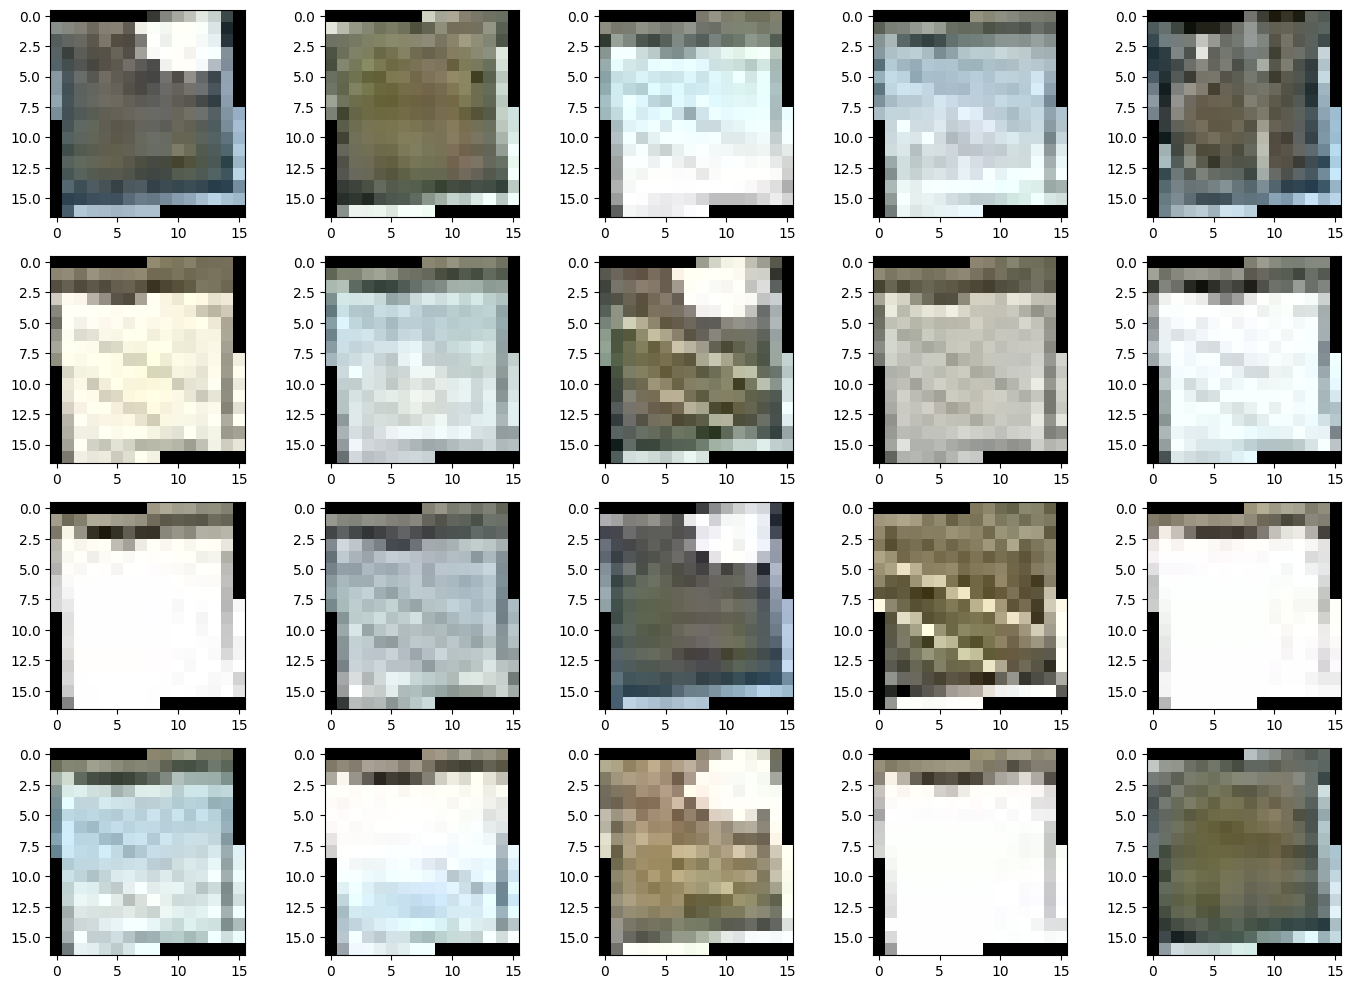

In [23]:
fig, ax = plt.subplots(4, 5, figsize=(14, 10))
axes = ax.flatten()
for i in range(20):
    axes[i].imshow(mirror_list[i])
plt.tight_layout()

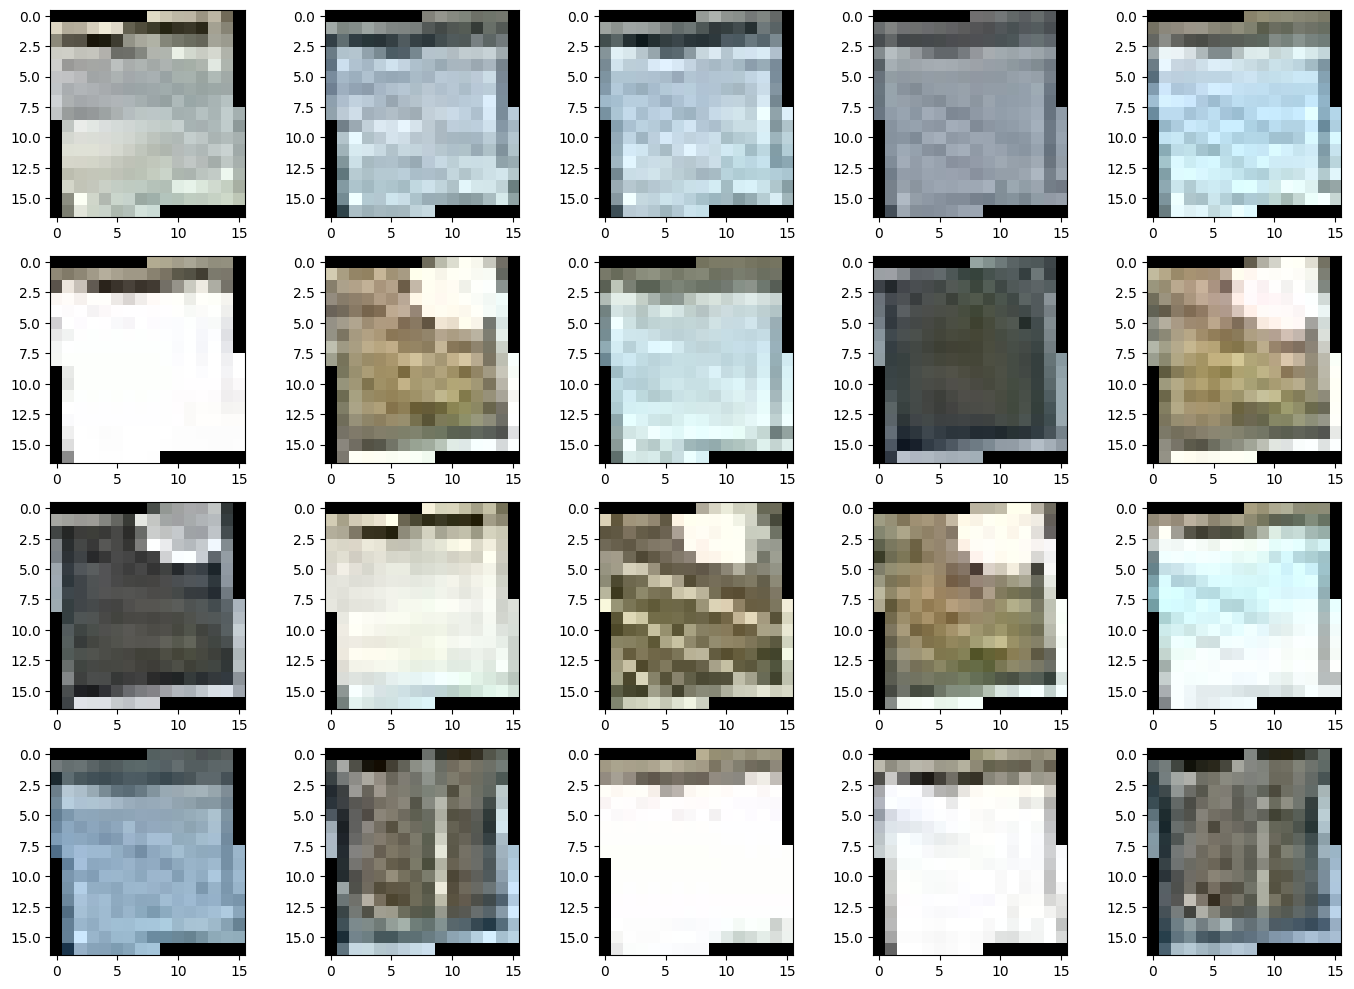

In [22]:
fig, ax = plt.subplots(4, 5, figsize=(14, 10))
axes = ax.flatten()
for i in range(20):
    axes[i].imshow(mirror_list[i+20])

plt.tight_layout()

In [15]:
mirror_features = compute_mirror_features(mirror_list)

In [16]:
df_mirror_features = pd.DataFrame(mirror_features)
df_mirror_features.head()

,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,brightness,brightness_std,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio
0,100.882353,62.382544,93.0,0,255,106.904412,63.863351,97.0,0,255,...,104.400735,64.120329,64.120329,6.551588,121.25,124.75,122.25,46.320801,0.110294,0.125000
1,109.860294,55.514462,113.0,0,248,110.503676,57.474483,110.0,0,255,...,103.776961,57.290126,57.290126,6.634583,129.00,125.25,99.00,47.086433,0.080882,0.126225
2,180.628676,78.775264,212.0,0,255,190.669118,82.064766,232.0,0,255,...,186.971814,81.669185,81.669185,6.149757,237.25,251.00,252.25,49.871683,0.627451,0.116422
3,161.812500,70.336728,185.0,0,248,174.242647,74.269877,202.0,0,255,...,171.204657,74.108201,74.108201,6.661788,208.00,221.00,226.00,48.522323,0.482843,0.113971
4,90.944853,49.958666,94.0,0,228,97.301471,53.909213,96.5,0,232,...,94.311275,53.845264,53.845264,6.779481,117.00,124.00,122.00,47.001330,0.041667,0.166667


In [19]:
df_mirror_features.agg(["mean", "std", "var"])

,R_mean,R_std,R_median,R_min,R_max,G_mean,G_std,G_median,G_min,G_max,...,brightness,brightness_std,contrast,entropy,dominant_R,dominant_G,dominant_B,gradient_magnitude,very_bright_ratio,very_dark_ratio
mean,149.385570,68.422991,169.037500,0.0,244.300000,154.213419,70.916190,174.637500,0.0,248.725000,...,151.031710,70.956230,70.956230,6.257868,190.362500,195.706250,191.518750,49.528155,0.352512,0.125950
std,38.777499,12.284598,56.255414,0.0,19.505686,38.734802,11.681334,59.140097,0.0,15.930921,...,39.145755,11.574894,11.574894,0.764001,50.327866,50.941422,54.954450,5.828668,0.268751,0.016021
var,1503.694391,150.911360,3164.671635,0.0,380.471795,1500.384892,136.453568,3497.551122,0.0,253.794231,...,1532.390131,133.978174,133.978174,0.583698,2532.894071,2595.028486,3019.991627,33.973375,0.072227,0.000257


<Axes: xlabel='brightness', ylabel='contrast'>

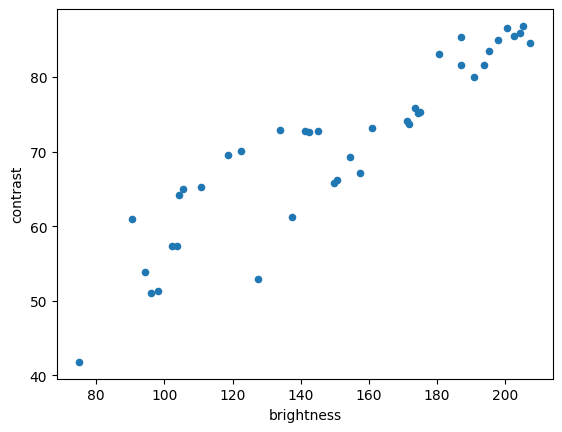

In [21]:
df_mirror_features.plot(kind="scatter", x="brightness", y="contrast")

<Axes: >

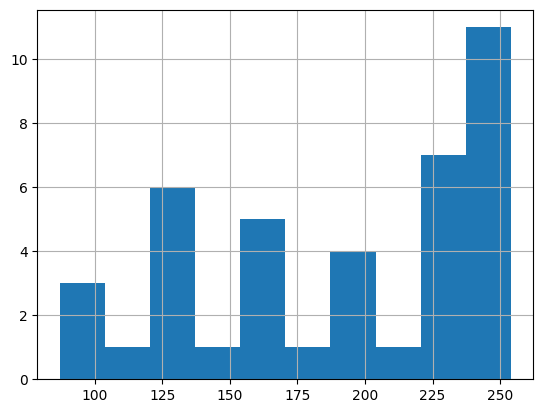

In [27]:
df_mirror_features["dominant_B"].hist()

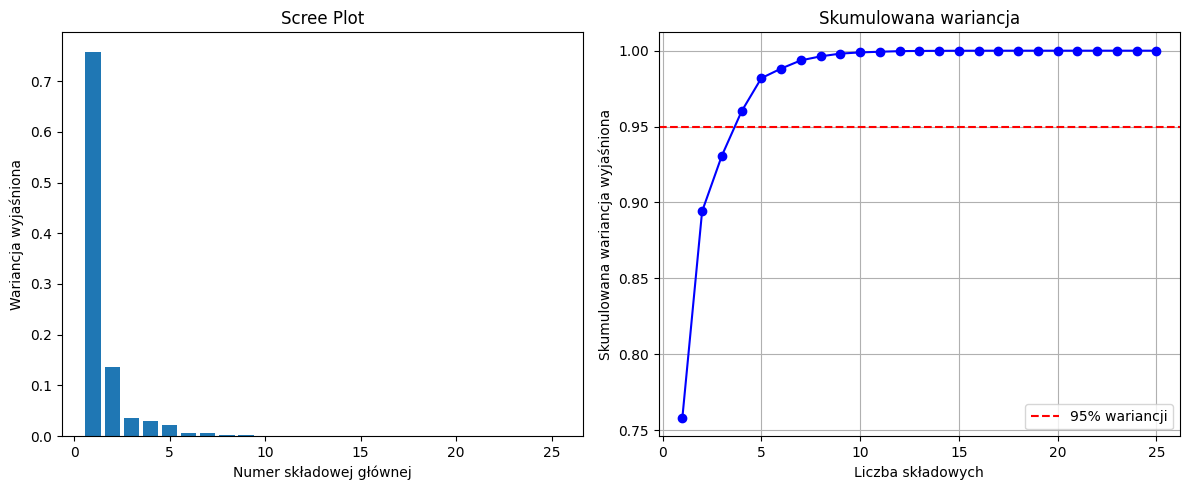

Liczba składowych dla 95% wariancji: 4


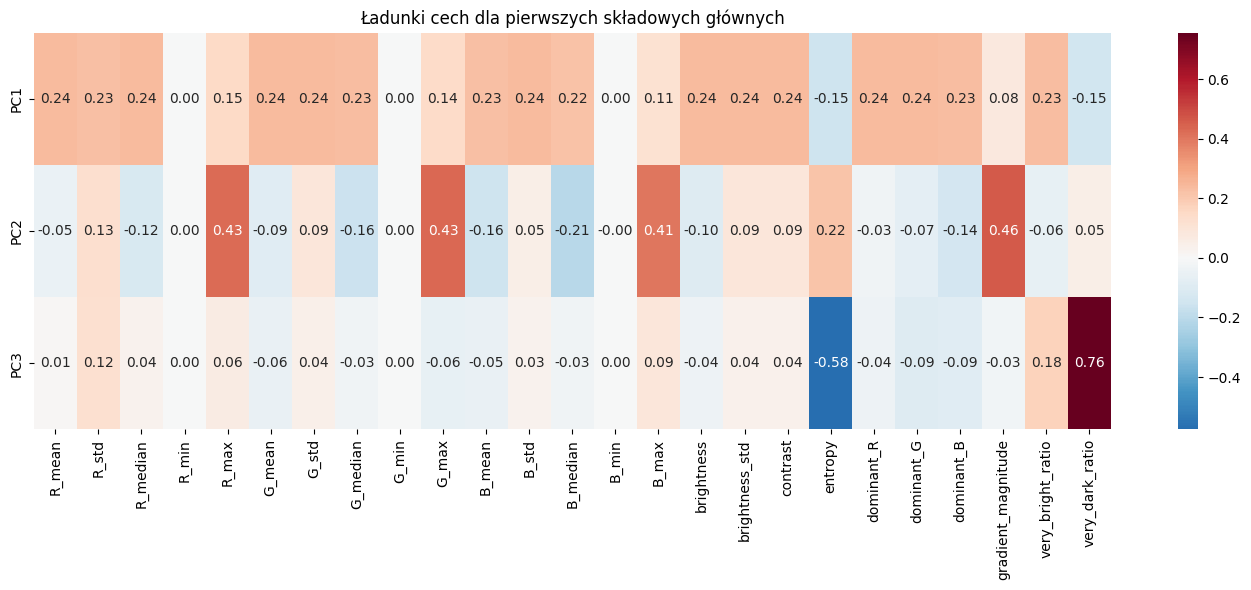


=== PC1 (wariancja: 75.80%) ===

Najsilniej dodatnie:
G_mean        0.240560
R_mean        0.240314
brightness    0.240214
G_std         0.239859
dominant_R    0.239698
dtype: float64

Najsilniej ujemne:
entropy           -0.154560
very_dark_ratio   -0.148163
R_min              0.000000
G_min              0.000000
B_min              0.000000
dtype: float64

=== PC2 (wariancja: 13.61%) ===

Najsilniej dodatnie:
gradient_magnitude    0.464514
G_max                 0.428608
R_max                 0.425397
B_max                 0.407239
entropy               0.217904
dtype: float64

Najsilniej ujemne:
B_median     -0.210239
G_median     -0.159548
B_mean       -0.159003
dominant_B   -0.137429
R_median     -0.120944
dtype: float64

=== PC3 (wariancja: 3.67%) ===

Najsilniej dodatnie:
very_dark_ratio      0.755797
very_bright_ratio    0.176470
R_std                0.119763
B_max                0.091212
R_max                0.059055
dtype: float64

Najsilniej ujemne:
entropy      -0.575333
dom

In [30]:
# Standaryzacja danych (kluczowe dla PCA!)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_mirror_features)

# PCA
pca = PCA()
pca_features = pca.fit_transform(df_scaled)

# 1. Analiza wariancji wyjaśnionej
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Wykres osypiska (scree plot)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Numer składowej głównej')
plt.ylabel('Wariancja wyjaśniona')
plt.title('Scree Plot')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% wariancji')
plt.xlabel('Liczba składowych')
plt.ylabel('Skumulowana wariancja wyjaśniona')
plt.title('Skumulowana wariancja')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Ile składowych potrzeba do 95% wariancji?
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Liczba składowych dla 95% wariancji: {n_components_95}")

# 2. Najważniejsze cechy - analiza ładunków (loadings)
# Weź pierwsze 2-3 składowe główne
n_top_components = 3
components_df = pd.DataFrame(
    pca.components_[:n_top_components],
    columns=df_mirror_features.columns,
    index=[f'PC{i+1}' for i in range(n_top_components)]
)

# Wizualizacja ładunków
plt.figure(figsize=(14, 6))
sns.heatmap(components_df, cmap='RdBu_r', center=0, annot=True, fmt='.2f')
plt.title('Ładunki cech dla pierwszych składowych głównych')
plt.tight_layout()
plt.show()

# Najważniejsze cechy dla każdej składowej
for i in range(n_top_components):
    print(f"\n=== PC{i+1} (wariancja: {explained_variance[i]:.2%}) ===")
    loadings = pd.Series(pca.components_[i], index=df_mirror_features.columns)
    top_positive = loadings.nlargest(5)
    top_negative = loadings.nsmallest(5)
    
    print("\nNajsilniej dodatnie:")
    print(top_positive)
    print("\nNajsilniej ujemne:")
    print(top_negative)

In [31]:

# Użyj tylko głównych składowych (np. tych wyjaśniających 95% wariancji)
pca_reduced = PCA(n_components=n_components_95)
pca_data = pca_reduced.fit_transform(df_scaled)

# Oblicz odległość Mahalanobisa w przestrzeni PCA
from scipy.spatial.distance import mahalanobis

# Centrum i macierz kowariancji
center = np.mean(pca_data, axis=0)
cov_matrix = np.cov(pca_data.T)
cov_inv = np.linalg.inv(cov_matrix)

# Odległości Mahalanobisa
mahal_distances = []
for i in range(len(pca_data)):
    dist = mahalanobis(pca_data[i], center, cov_inv)
    mahal_distances.append(dist)

mahal_distances = np.array(mahal_distances)

# Threshold - rozkład chi-kwadrat
from scipy.stats import chi2
threshold = chi2.ppf(0.975, df=n_components_95)  # 97.5% percentyl

outliers_mahal = mahal_distances > threshold

print(f"\nLiczba outlierów (Mahalanobis): {outliers_mahal.sum()}")
print(f"Indeksy outlierów: {np.where(outliers_mahal)[0]}")


Liczba outlierów (Mahalanobis): 0
Indeksy outlierów: []


In [41]:
threshold = 2.3
outliers_mahal = mahal_distances > threshold

print(f"\nLiczba outlierów (Mahalanobis): {outliers_mahal.sum()}")
print(f"Indeksy outlierów: {np.where(outliers_mahal)[0]}")


Liczba outlierów (Mahalanobis): 6
Indeksy outlierów: [ 4 23 28 30 32 35]


In [32]:
mahal_distances

array([1.537019  , 1.51817255, 1.03507604, 1.33599899, 2.32663192,
       1.63017269, 1.29922879, 1.71713922, 1.731944  , 1.25551923,
       2.04324448, 1.71649348, 1.51473706, 2.19005548, 1.79600653,
       1.21900385, 1.16318662, 1.89285743, 1.78506793, 2.28091973,
       0.10499596, 1.5451707 , 1.06812839, 4.37325862, 1.49376659,
       2.12143217, 1.763551  , 1.45218103, 3.7673099 , 1.69443284,
       2.85668068, 1.19775993, 2.72453856, 1.76262916, 1.10198158,
       2.97701662, 2.29570781, 2.07505029, 1.51514644, 2.27845435])

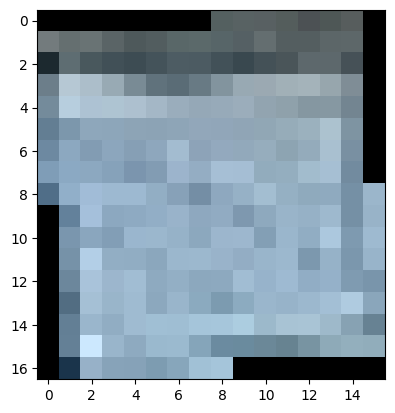

In [47]:
plt.imshow(mirror_list[35])

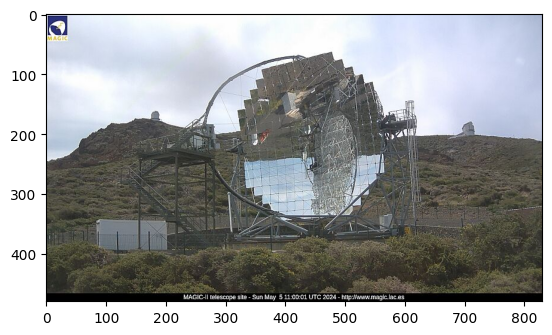

In [48]:
img = np.array(Image.open(img_list[35]).convert('RGB'))

plt.imshow(img)